In [ ]:
# paths.py
from pathlib import Path

#: Always points to the root of the project
PROJECT_ROOT = Path(__file__).resolve().parent

# 1. Data preparation

Load a single `.mzML` from `data/rawfiles/`, inspect its contents, filter to positive‐ion spectra only, apply quality control, and cache as a clean HDF5.

We do positive because DreaMS were rained only on single charge positive ionizations

In [1]:
# 1) prep imports & repo‐root‐aware paths
import sys
from pathlib import Path
import numpy as np
import pandas as pd

# make PROJECT_ROOT available
sys.path.append(str(Path().resolve().parent))
from paths import PROJECT_ROOT

# DreaMS imports
from dreams.utils.data import MSData
from dreams.utils.dformats import DataFormatA
from dreams.utils.spectra import unpad_peak_list
from dreams.utils.io import append_to_stem

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


## 1.1 Place you path to file here

In [2]:
# 2) define the input file and HDF5 cache path
mzml_path = PROJECT_ROOT / "data" / "rawfiles" / "202312_20_P09-Leaf-r1_1uL.mzML"
h5_path   = mzml_path.with_suffix(".hdf5")

In [3]:
# 3) load or cache to HDF5
if h5_path.exists():
    msdata = MSData.from_hdf5(h5_path, in_mem=True)
else:
    msdata = MSData.from_mzml(mzml_path, in_mem=True)

Loading dataset 202312_20_P09-Leaf-r1_1uL into memory (5681 spectra)...


In [4]:
# 4) inspect which columns/attributes we have
print("columns in MSData:", msdata.columns())

columns in MSData: ['RT', 'charge', 'file_name', 'precursor_mz', 'scan_number', 'spectrum']


## Visualize spectra at location 0. 

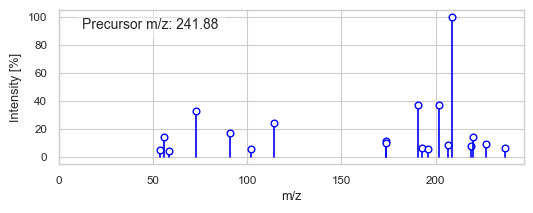

{'RT': 31.506183936,
 'charge': 0,
 'file_name': '202312_20_P09-Leaf-r1_1uL.mzML',
 'precursor_mz': 241.884170532227,
 'scan_number': 86}

In [9]:
msdata.at(0)

### here is important and one instance holds infrmation from input file, plus its file name and scan_number which works for spectra identification and will be maintain over all tutorial to trace back processed spectra to origin

In [13]:
# 3) Retrieve all m/z–intensity arrays (padded):
spectra = msdata.get_spectra()  # numpy ndarray, shape (N,2,P)
print(spectra.shape)

(5681, 2, 128)


## So our file containg 5681 spectra, then we have one array just for mzs and second for its intensities.

In [14]:
# 4) Inspect one spectrum (with zeros = padding):
import numpy as np
np.set_printoptions(precision=4, suppress=True)
print(spectra[0])

[[   53.8327    55.9341    58.6939    72.9368    90.9475   102.0474
    113.9632   173.5249   173.5422   190.8727   192.8889   195.9438
    201.8877   206.8678   208.8836   218.8892   219.8978   226.8952
    236.8765     0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         0.         0.         0.         0.
      0.         0.         

In [15]:
# 5) Remove padding zeros:
s0 = unpad_peak_list(spectra[0])
print(s0)  # shape (n_peaks, 2)

[[   53.8327    55.9341    58.6939    72.9368    90.9475   102.0474
    113.9632   173.5249   173.5422   190.8727   192.8889   195.9438
    201.8877   206.8678   208.8836   218.8892   219.8978   226.8952
    236.8765]
 [ 2280.      6953.      2213.     16069.      8479.      2597.
  11877.      5660.      4897.     18228.      3265.      2667.
  17993.      4307.     48795.      3700.      7047.      4330.
   3223.    ]]


### To get specific element one can do:

### For one attribute, eg. charge

In [16]:
msdata.get_values('charge') 


array([0, 1, 1, ..., 0, 1, 1])

#### For specific location 

In [17]:
msdata.get_values('charge', [0])  

array([0])

#### For  multiple records of same elements

In [18]:
msdata.get_values('charge', [0, 1, 2, 3])  

array([0, 1, 1, 1])

## Here we remove unneeded mass spectra that contain others then positive charge

In [5]:
# 5) filter to positive‐ion spectra only
charges = msdata.get_values("charge")   # shape: (N,)
pos_idx = np.where(charges > 0)[0]
print(f"keeping {len(pos_idx)} / {len(charges)} spectra with charge > 0")

# optionally, write a subsetted HDF5 for later reuse:
hq_h5 = PROJECT_ROOT / "data" / "rawfiles" / "202312_20_P09-Leaf-r1_1uL_pos.hdf5"
msdata_pos = msdata.form_subset(pos_idx, out_pth=hq_h5)

keeping 4562 / 5681 spectra with charge > 0


## This is requeired for QC 
We need to pull mass spectra and precursor mz for quality control and it have to be in shape of (M, 2, P) and (M,), you do not need to care, it is solved internaly.
# TODO add image here

In [6]:
# 6) pull out spectra & precursor m/z arrays (unpadded!)
spectra = msdata_pos.get_spectra()    # (M, 2, P) padded
prec_mzs = msdata_pos.get_prec_mzs()  # (M,)

# unpad each spectrum before any intensity‐based checks
spectra = [ unpad_peak_list(s) for s in spectra ]

In [7]:
# 7) compute single‐spectrum QC flags
dformat      = DataFormatA()
quality_lvls = [
    dformat.val_spec(spec, prec, return_problems=True)
    for spec, prec in zip(spectra, prec_mzs)
]

# tally results
pd.Series(quality_lvls).value_counts()

All checks passed                      2000
Intensity amplitude >= 20.0            1783
Number of high intensity peaks >= 3     764
m/z range <= 1000.0                      15
Name: count, dtype: int64

## so now we are preserving 2000 mass spectra, rest will be removed 

In [8]:
# 8) keep only those that passed *all* metrics
pass_idx = np.where(np.array(quality_lvls) == "All checks passed")[0]
print(f"{len(pass_idx)} spectra passed all QC out of {len(quality_lvls)}")

clean_h5 = append_to_stem(h5_path, "high_quality")
msdata_hq = msdata_pos.form_subset(pass_idx, out_pth=clean_h5)
print(msdata_hq)

2000 spectra passed all QC out of 4562
MSData(pth=/Users/macbook/CODE/DreaMS_MIMB/data/rawfiles/202312_20_P09-Leaf-r1_1uL_high_quality.hdf5, in_mem=False) with 2,000 spectra.


## Next
**Next:** you now have a clean, positive‐ion, high‐quality HDF5 for downstream embedding and clustering.  
Proceed to **2_lsh_and_clustering.ipynb** for LSH deduplication & DreamS encoding.